## Content-Based Image Retrieval

* Download the dataset [here](https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip
)
* create a dataset directory
* extract the zip, rename the folder into "scenes" and put it into dataset folder

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Create the dataset from the images in dataset folder 

from glob import glob
from sklearn.model_selection import train_test_split 
import pandas as pd 

filenames = glob('dataset/scenes/*.jpg')
extract_classes = lambda x: x.split('/')[2].split('_')[0]
classes = list(map(extract_classes, filenames))
df = pd.DataFrame({'filename': filenames, 'class': classes})
_, df = train_test_split(df, test_size = .3) ## take a subset

In [3]:
train_df, test_df = train_test_split(df, test_size = .15)

In [11]:
from tqdm import tqdm
import numpy as np
from skimage import io 
from cyvlfeat.sift import dsift  

## extract SIFT descriptors from images
def extract_sift (data, size = 5, step = 10): 
    descriptors = []
    for i, row in tqdm(data.iterrows(), "Extracting/Describing patches", total = len(data)):
        im = io.imread(row['filename'], as_gray = True)
        _, desc = dsift(im, size = size, step = step)
        descriptors.append(desc)
    return np.vstack(descriptors)

In [12]:
train_descriptors = extract_sift(train_df)

Extracting/Describing patches: 100%|██████████| 685/685 [01:02<00:00, 10.94it/s]


In [13]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(500) 
kmeans.fit(train_descriptors)

def image_tokenizer (filename, size = 5, step = 10, kmeans = kmeans):
    im = io.imread(filename, as_gray = True)
    _, descriptors = dsift(im, size = size, step = step)
    tokens = kmeans.predict(descriptors)
    return tokens


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer = image_tokenizer, vocabulary = range(500), use_idf = True)
tfidf.fit_transform(train_df['filename'])

<685x500 sparse matrix of type '<class 'numpy.float64'>'
	with 123130 stored elements in Compressed Sparse Row format>

In [15]:
x_train = tfidf.transform(train_df['filename'])
y_train = train_df['class']

x_test = tfidf.transform(test_df['filename'])
y_test = test_df['class']

In [16]:
from sklearn.neighbors import KDTree

tree = KDTree(x_train.todense())

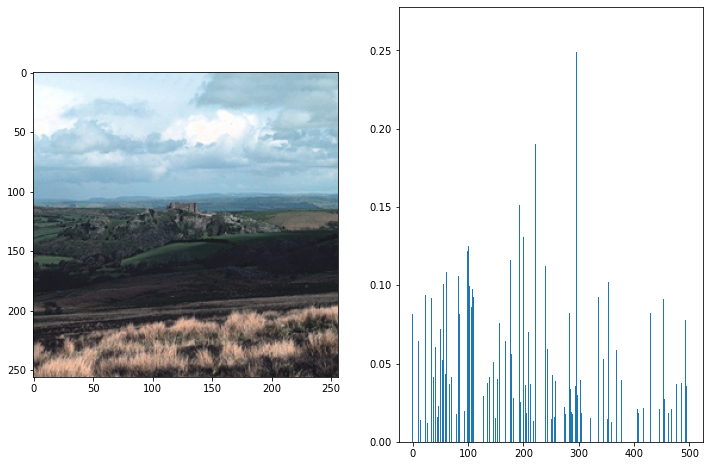

In [41]:
from matplotlib import pyplot as plt


query_id = np.random.randint(0, len(test_df) - 1)
query_im = io.imread(test_df.iloc[query_id]['filename'])
query_features = np.array(x_test.todense()[query_id])

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(query_im)
plt.subplot(122)
plt.bar(range(query_features.shape[1]),query_features[0])
plt.show()

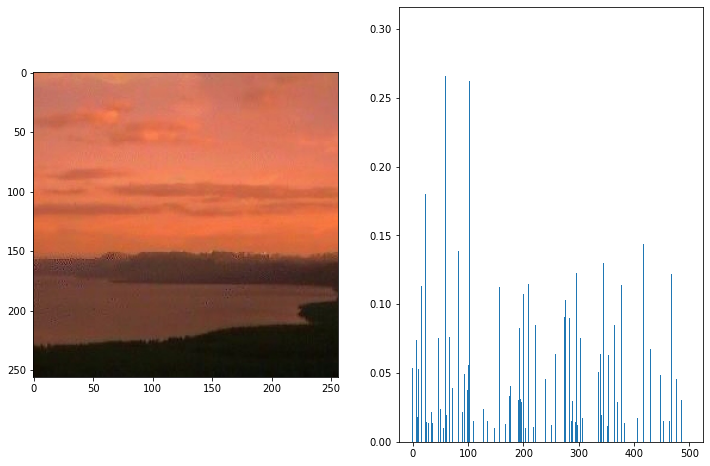

In [42]:
distance, index = tree.query(query_features)
index = index[0][0]
matched_im = io.imread(train_df.iloc[index]['filename'])
matched_features = np.array(x_train.todense()[index])

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(matched_im)
plt.subplot(122)
plt.bar(range(matched_features.shape[1]),matched_features[0])
plt.show()